In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools

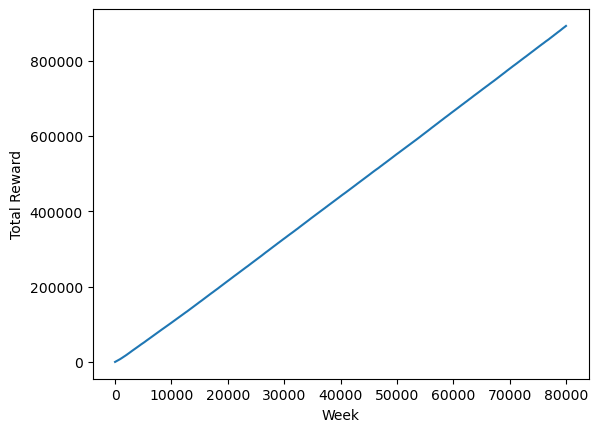

State: (0, 0, (0, 0, 0, 0, 0, 0, 0), ('no response', 'no response', 'no response', 'no response', 'no response', 'no response', 'no response'), (0, 0, 0, 0, 0, 0, 0))
Action 0: Q-value 0.09004713193977046
Action 1: Q-value 5.395875426014508
State: (1, 0, (0, 0, 0, 0, 0, 0, 0), ('no response', 'no response', 'no response', 'no response', 'no response', 'no response', 'no response'), (0, 0, 0, 0, 0, 0, 0))
Action 0: Q-value 0.21641970384375184
Action 1: Q-value -0.009886722470335656
State: (2, 0, (0, 0, 0, 0, 0, 0, 0), ('no response', 'no response', 'no response', 'no response', 'no response', 'no response', 'no response'), (0, 0, 0, 0, 0, 0, 0))
Action 0: Q-value 0.4669044052614866
Action 1: Q-value -9.484798313038913e-05
State: (3, 0, (0, 0, 0, 0, 0, 0, 0), ('no response', 'no response', 'no response', 'no response', 'no response', 'no response', 'no response'), (0, 0, 0, 0, 0, 0, 1))
Action 0: Q-value 0.0
Action 1: Q-value 0
State: (4, 0, (0, 0, 0, 0, 0, 0, 0), ('no response', 'no res

In [4]:
#Q-learning algorithm

np.random.seed(1234)  # set the seed

class Environment:
    def __init__(self):
        self.time_slots = 5
        self.days = 7  
        #self.weeks = 4
        #self.steps_before = 158
        #self.target_steps = 6083 / 7  # Change to target steps per day
        #Current state: time_slot, day, history of steps, history of feedback, history of actions
        self.state = (0, 0, [0]*self.days, ['no response']*self.days, [0]*self.days)  # Initialize state with history of past 1 day
        self.state_space = [(i, j, k, l, m) for i in range(self.time_slots) for j in range(self.days) for k in itertools.product(range(2), repeat=self.days) for l in ['good', 'bad', 'no response'] for m in itertools.product(range(2), repeat=self.days)]
        self.action_space = [0, 1]  # send_notification or not


    def reset(self):
        self.state = (0, 0, [0]*self.days, ['no response']*self.days, [0]*self.days)
        self.steps_before = 0
        return self.state
    
    def step(self, action):
    

        # Define the probabilities for each time slot
        feedback_probs = {
            1: {'good': 0.139896, 'bad': 0.132124, 'no response': 0.727979},
            2: {'good': 0.207865, 'bad': 0.084270, 'no response': 0.707865},
            3: {'good': 0.228495, 'bad': 0.118280, 'no response': 0.653226},
            4: {'good': 0.191011, 'bad': 0.106742, 'no response': 0.702247},
            5: {'good': 0.178378, 'bad': 0.162162, 'no response': 0.659459},
        }

        # Get the current time slot and day
        current_time_slot, current_day = self.state[0], self.state[1]

        if action == 0:
            feedback = 'no response'
        else:
            # Get the feedback probabilities for the current time slot
            feedback_prob = feedback_probs[current_time_slot + 1]  # +1 because time slots in the dictionary start from 1

            # Normalize the probabilities if they don't sum to 1
            total = sum(feedback_prob.values())
            for key in feedback_prob:
                feedback_prob[key] /= total

            # Choose the feedback based on the probabilities
            feedback = np.random.choice(['good', 'bad', 'no response'], p=[feedback_prob['good'], feedback_prob['bad'], feedback_prob['no response']])
        
        if action:
            change_steps = 1 if random.random() < 0.3736 else 0 # steps increased 37.36% of the time, record as 1
        else:
            change_steps = 0  # steps not increased, record as 0
            
        #print("Action chosen:", action)
        #print("Feedback received:", feedback)
        #print("Change in steps:", change_steps)

        self.steps_before += change_steps

        # Update time slot and day
        current_time_slot, current_day = self.state[0], self.state[1]
        next_time_slot = (current_time_slot + 1) % self.time_slots
        next_day = (current_day + (1 if next_time_slot == 0 else 0)) % self.days

        # Update state
        history_steps = list(self.state[2])  # copy the history of steps
        history_steps.pop(0)  # remove the oldest day
        history_steps.append(change_steps)  # add today's change to the history

        history_feedback = list(self.state[3])  # copy the history of feedback
        history_feedback.pop(0)  # remove the oldest day
        history_feedback.append(feedback)  # add today's feedback to the history

        history_action = list(self.state[4])  # copy the history of actions
        history_action.pop(0)  # remove the oldest day
        history_action.append(action)  # add today's action to the history

        #Next state: time_slot, day, history of steps, history of feedback, history of actions
        self.state = (next_time_slot, next_day, history_steps, history_feedback, history_action)

        reward = 0
        
        # check if a day has ended
        if next_time_slot == 0:  # if the current time slot is the last one of the day
            # if the goal is reached in a day
            if sum(history_steps[-self.time_slots:]) >= 1:  # assuming the goal is to have at least 1 increased steps/day
                reward += 5
        if feedback == 'good':
            reward += 1
        elif feedback == 'bad':
            reward -= 1

        done = False

        # check if a week has ended
        if self.state[1] == 6:  # if the current day is the last day of the week
            done = True
        else:
            done = False

        return self.state, reward, done

class Agent:
    def __init__(self, env):
        self.env = env
        self.actions = [0, 1]
        self.q_table = {}  # Initialize Q-table as an empty dictionary
        self.alpha = 1.0  # start with full learning
        self.alpha_min = 0.01  # minimum learning
        self.alpha_decay = 0.995  # decay rate
        self.gamma = 0.95 #higher than before
        self.epsilon = 1.0  # start with full exploration
        self.epsilon_min = 0.01  # minimum exploration
        self.epsilon_decay = 0.995  # decay rate
        
    def choose_action(self, state):
        state_key = tuple(tuple(x) if isinstance(x, list) else x for x in state)
        if state_key not in self.q_table:
            self.q_table[state_key] = {action: 0 for action in self.env.action_space}
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(self.env.action_space)
            #print("Exploration Phase - Random Action Chosen:", action)
        else:
            action = max(self.q_table[state_key], key=self.q_table[state_key].get)
            #print("Exploitation Phase - Action with Highest Q-value Chosen:", action)

        # Decay epsilon after each action selection
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return action


    def update_q_table(self, state, action, reward, next_state):
        state_key = tuple(tuple(x) if isinstance(x, list) else x for x in state)
        next_state_key = tuple(tuple(x) if isinstance(x, list) else x for x in next_state)

        if state_key not in self.q_table:
            self.q_table[state_key] = {action: 0 for action in self.actions}  # Initialize Q-values for new state
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = {action: 0 for action in self.actions}  # Initialize Q-values for new state

        self.q_table[state_key][action] = (1 - self.alpha) * self.q_table[state_key][action] \
            + self.alpha * (reward + self.gamma * max(self.q_table[next_state_key].values()))
        
        # Decay alpha after each update
        if self.alpha > self.alpha_min:
            self.alpha *= self.alpha_decay
            
    def train(self, total_episodes):
        weekly_rewards = []
        weekly_reward = 0
        for episode in range(total_episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                weekly_reward += reward

            # Print exploration rate (epsilon)
            #print("Exploration rate (epsilon):", self.epsilon)

            weekly_rewards.append(weekly_reward)

        # plot rewards
        plt.plot(weekly_rewards)
        plt.xlabel('Week')
        plt.ylabel('Total Reward')
        plt.show()

        #def moving_average(a, n=3) :
            #ret = np.cumsum(a, dtype=float)
            #ret[n:] = ret[n:] - ret[:-n]
            #return ret[n - 1:] / n
        
        # calculate moving average of rewards
        #moving_avg_rewards = moving_average(weekly_rewards, n=10)  # n is the window size

        # plot moving average of rewards
        #plt.plot(moving_avg_rewards)
        #plt.xlabel('Week')
        #plt.ylabel('Moving Average of Total Reward')
        #plt.show()

    def print_q_table(self):
        for state, action_values in self.q_table.items():
            print("State:", state)
            for action, value in action_values.items():
                print(f"Action {action}: Q-value {value}")

    def evaluate(self):
        state = self.env.reset()
        total_reward = 0
        done = False
        while not done:
            state_key = tuple(tuple(x) if isinstance(x, list) else x for x in state)
            if state_key in self.q_table:
                action = max(self.q_table[state_key], key=self.q_table[state_key].get)
            else:
                action = np.random.choice(self.env.action_space)
            #print(f"State: {state_key}, Chosen Action: {action}")
            state, reward, done = self.env.step(action)
            total_reward += reward
        return total_reward

env = Environment()
agent = Agent(env)
agent.train(10000)
agent.print_q_table()
print("Total reward after evaluation:", agent.evaluate())

Mean Reward: 11.22
Standard Deviation of Reward: 5.0805117852436865


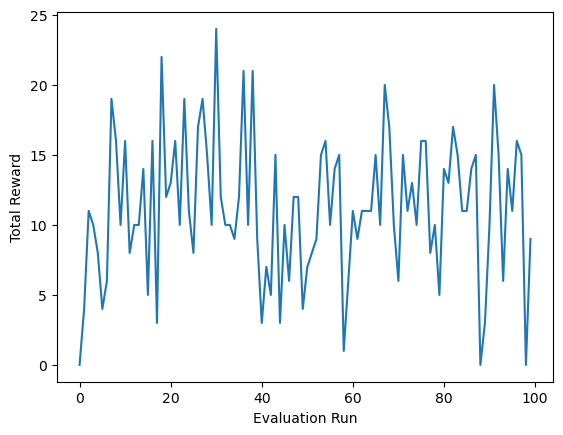

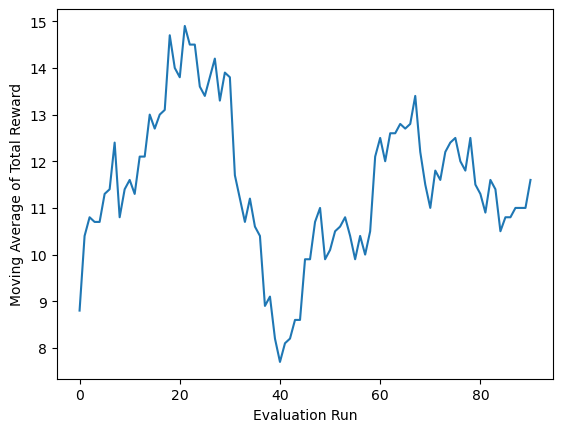

In [5]:
# Agent evaluated after the training process. Exploiting the knowledge.
# Number of evaluations
num_evaluations = 100

# List to store the total rewards for each evaluation
total_rewards = []

for _ in range(num_evaluations):
    total_reward = agent.evaluate()
    total_rewards.append(total_reward)

# Calculate mean and standard deviation
mean_reward = np.mean(total_rewards)
std_reward = np.std(total_rewards)

print("Mean Reward:", mean_reward)
print("Standard Deviation of Reward:", std_reward)

# Plot the total rewards
plt.plot(total_rewards)
plt.xlabel('Evaluation Run')
plt.ylabel('Total Reward')
plt.show()

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Calculate moving average of total rewards
moving_avg_rewards = moving_average(total_rewards, n=10)  # n is the window size

# Plot moving average of total rewards
plt.plot(moving_avg_rewards)
plt.xlabel('Evaluation Run')
plt.ylabel('Moving Average of Total Reward')
plt.show()

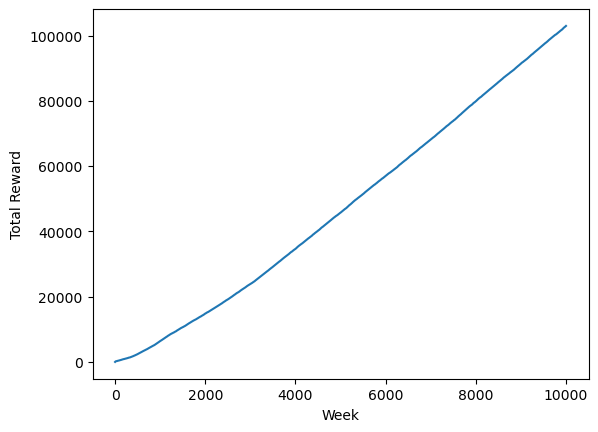

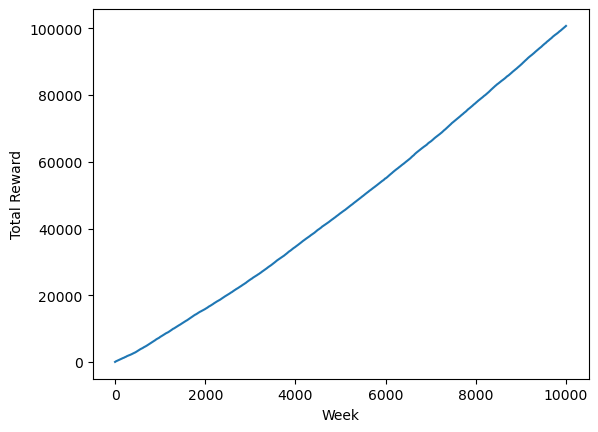

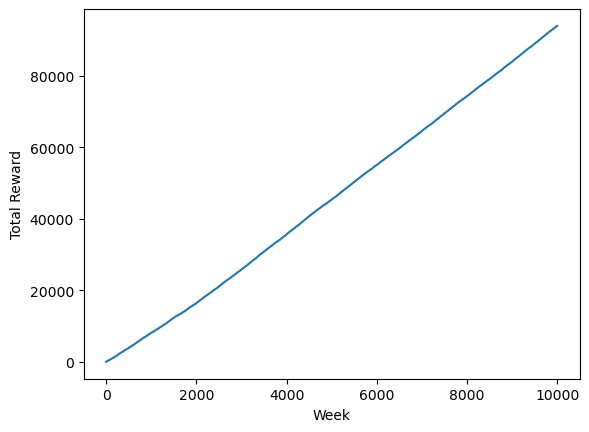

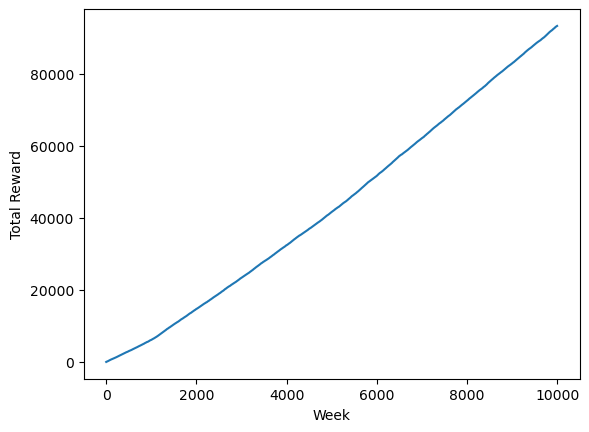

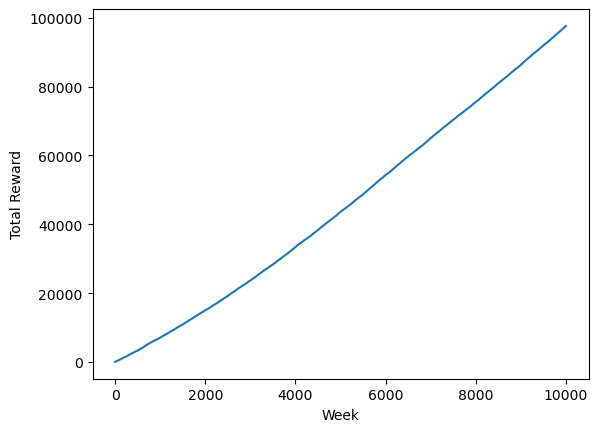

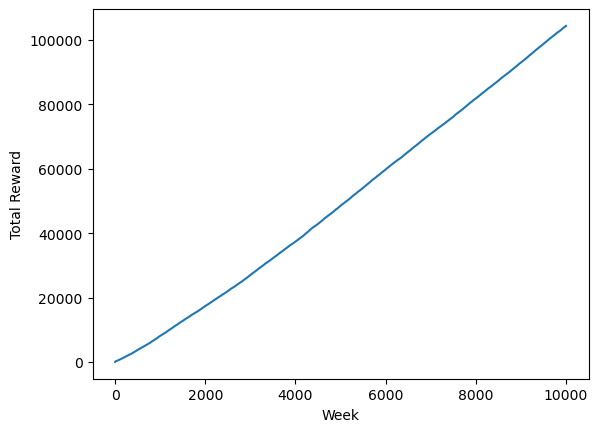

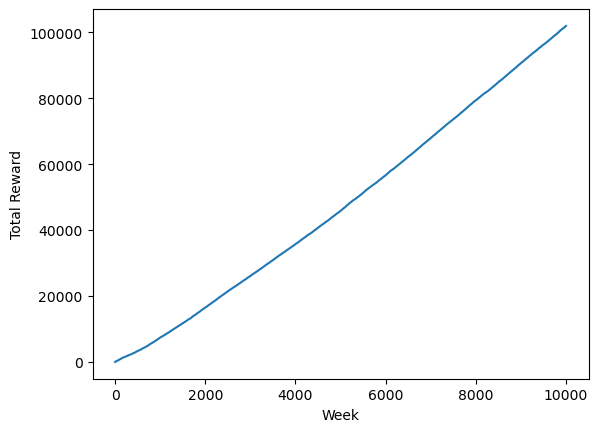

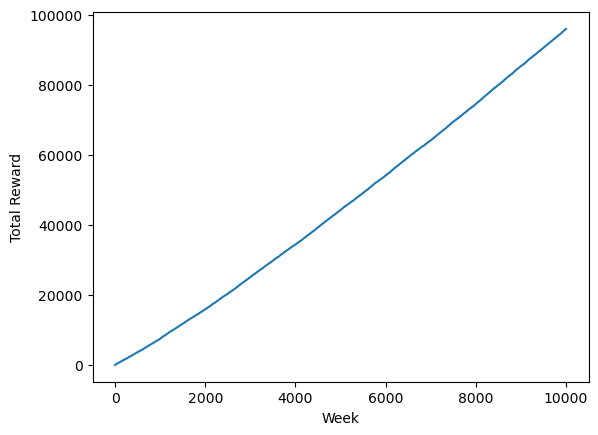

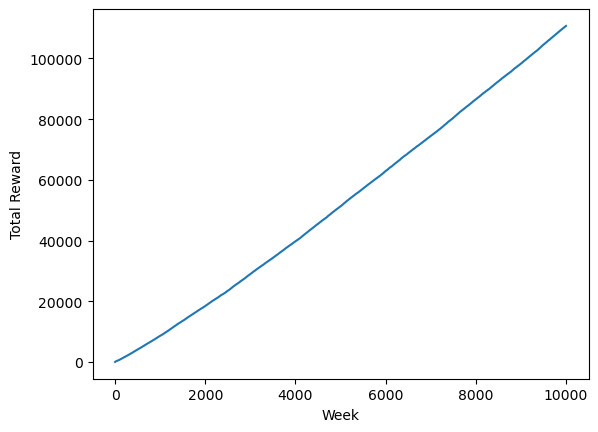

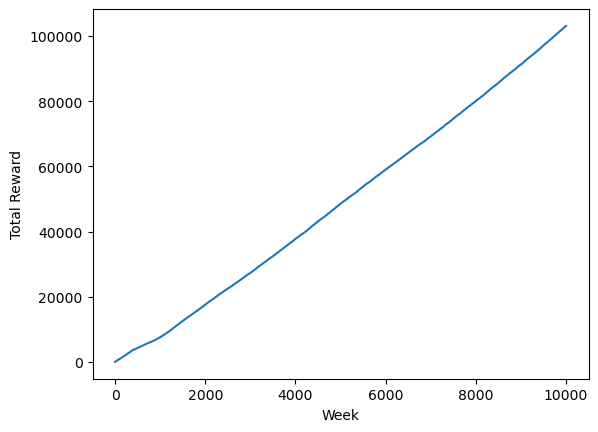

Mean Reward: 12.7
Standard Deviation of Reward: 4.712748667179271


In [20]:

# Define the number of runs
num_runs = 10

# List to store the rewards obtained from each run
all_rewards = []

for _ in range(num_runs):
    env = Environment()  # Create a new environment for each run
    agent = Agent(env)  # Create a new agent for each run
    agent.train(10000)  # Train the agent for a fixed number of episodes
    total_reward = agent.evaluate()  # Evaluate the agent after training
    all_rewards.append(total_reward)  # Store the total reward obtained from this run

# Compute the mean and standard deviation of rewards across all runs
mean_reward = np.mean(all_rewards)
std_reward = np.std(all_rewards)

print("Mean Reward:", mean_reward)
print("Standard Deviation of Reward:", std_reward)
